In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET
import omnifold_routine
import PET
from my_utils import *
GPU_number="5"

os.environ['CUDA_VISIBLE_DEVICES']=GPU_number # GPU Server Available: 0,1,2,3,4,5,6,7
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']=GPU_number
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2026-01-08 08:42:20.025632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 08:42:20.654051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767858140.847784 1555279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767858140.895399 1555279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767858141.414561 1555279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pythia_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

pythia_train, pythia_test = subset(pythia_df[pythia_df['pass_matched']==1], 10_000_000, train_test=True)
herwig_subset = subset(herwig_df[herwig_df['pass_matched']==1], 10_000_000, train_test=False)

#pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
#pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
#herwig_reco, herwig_truth = MC_data_shaper(herwig_subset)
pythia_reco_train, pythia_truth_train = np.concatenate([MC_data_shaper(pythia_train)[0], pairwise(MC_data_shaper(pythia_train)[0])], axis=1), np.concatenate([MC_data_shaper(pythia_train)[1], pairwise(MC_data_shaper(pythia_train)[1])], axis=1)
pythia_reco_test, pythia_truth_test = np.concatenate([MC_data_shaper(pythia_test)[0], pairwise(MC_data_shaper(pythia_test)[0])], axis=1), np.concatenate([MC_data_shaper(pythia_test)[1], pairwise(MC_data_shaper(pythia_test)[1])], axis=1)
herwig_reco, herwig_truth = np.concatenate([MC_data_shaper(herwig_subset)[0], pairwise(MC_data_shaper(herwig_subset)[0])], axis=1), np.concatenate([MC_data_shaper(herwig_subset)[1], pairwise(MC_data_shaper(herwig_subset)[1])], axis=1)


In [14]:
data_df = pd.read_pickle('/ptmp/mpp/mjosef/data_files/WbWb_files/bulk_region/df_data.pkl')
print(len(data_df))

4301954


In [3]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [4]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)
Y_truth_scaled = jet_scaler.transform(pythia_truth_test)
Y_reco_scaled = jet_scaler.transform(pythia_reco_test)

herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_subset['eventWeight'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],normalize=False)

INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


## Let's now create the neural network models we are going to use to model the weight distributions

In [5]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 14 # 14 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 14, local=True, K=4)
model2 = PET.PET(num_feat = 4, num_part = 14, local=True, K=4)

I0000 00:00:1767858777.595972 1555279 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 139696 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:a3:00.0, compute capability: 9.0


## Let's now unfold!

In [6]:
omnifold_name = "14_part_10000000_evts_ensemble"
weight_folder = '/scratch/mjosef/Unfolding/omnifold/PET/'

omnifold = omnifold_routine.MultiFold(
    omnifold_name,
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = weight_folder,
    verbose = True,
    early_stop=5,
    lr = 5e-4,
)

156250 training steps at reco and 156250 steps at gen


In [31]:
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 2.1420 - val_loss: 2.1154 - learning_rate: 5.0000e-05
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 2.1193 - val_loss: 2.1097 - learning_rate: 5.0000e-05
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 2.1176 - val_loss: 2.1077 - learning_rate: 5.0000e-05
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 2.1142 - val_loss: 2.1066 - learning_rate: 5.0000e-05
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 2.1130 - val_loss: 2.1051 - learning_rate: 5.0000e-05
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 2.1106 - val_loss: 2.1045 - learning_rate: 5.0000e-05
Epoc

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

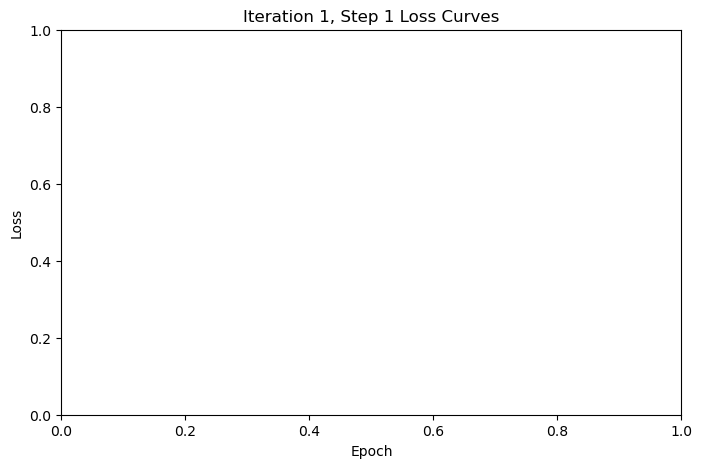

In [9]:
import pickle
import os
# Set these to your parameters
niter = 3                       
n_ensemble = 2               
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weight_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


## Now, let's evaluate the model!

In [33]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)  

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


## 14 Particles

In [7]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from tensorflow.keras.models import clone_model
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met',
             'min_mbl', 'max_mbl'
             ]
pt_binning = {
    'l1': np.linspace(0, 700, 16),
    'b1': np.linspace(0, 400, 21),
    'b2': np.linspace(0, 300, 21),
    'b3': np.linspace(0, 200, 16),
    'b4': np.linspace(0, 150, 12),
    'j1': np.linspace(0, 500, 26),
    'j2': np.linspace(0, 400, 21),
    'j3': np.linspace(0, 300, 16),
    'j4': np.linspace(0, 250, 16),
    'j5': np.linspace(0, 200, 16),
    'j6': np.linspace(0, 150, 12),
    'met': np.linspace(0, 300, 31),
    'min_mbl': np.linspace(0, 600, 21),
    'max_mbl': np.linspace(0, 600, 21),
}
particle_index = 1
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins, logx=False):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    ref_name = next(iter(data_dict.keys()))
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    # Omnifold uncertainties: sum of weights squared per bin
    sum_w2_dict = {}
    err_dict = {}
    for label, values in data_dict.items():
        w2 = weights_dict[label]**2
        sum_w2, _ = np.histogram(values, bins=bins, weights=w2)
        sum_w2_dict[label] = sum_w2
        err_dict[label] = np.sqrt(sum_w2)
    maxy = 0
    base_colors = [
        'black',        # reference
        '#3f90da',      # MC
        '#ffa90e',      # OmniFold(it)
        'lime',        # OmniFold(it-1)
    ]
    base_linestyles = [
        '-',    # reference
        '-',    # MC
        '-',    # OmniFold(it)
        '--',   # OmniFold(it-1)
    ]
    base_err_colors = [
        None,
        '#3f90da',
        '#ffa90e',
        'lime',
    ]

    labels = list(data_dict.keys())
    n_curves = len(labels)

    colors = base_colors[:n_curves]
    linestyles = base_linestyles[:n_curves]
    err_colors = base_err_colors[:n_curves]

    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], linestyle=linestyles[i], label=label)
        # error band for blue/orange curves (Omnifold)
        if i > 0:
            # ratio and propagated error
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts != 0)
            ratio_err = np.zeros_like(ratio)
            nonzero = (ref_counts != 0)
            ratio_err[nonzero] = ratio[nonzero] * np.sqrt(
                (err_dict[label][nonzero] / counts[nonzero])**2 +
                (err_dict[ref_name][nonzero] / ref_counts[nonzero])**2
            )

            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], linestyle=linestyles[i], label=label)
            ax_ratio.fill_between(
                x_centers,
                ratio - ratio_err,
                ratio + ratio_err,
                step='mid',
                alpha=0.3,
                color=err_colors[i],
            )
        maxy = max(maxy, counts.max())
    if logx:
        ax_main.set_xscale('log')
    #ax_main.set_ylim(0, 1.3 * maxy)
    ax_main.set_yscale('log')
    ax_main.grid(True, ls='--', alpha=0.5)
    ax_main.legend(fontsize=9)
    ax_ratio.axhline(1.0, color='r', ls='--')
    ax_ratio.set_ylim(0.9, 1.1)
    ax_ratio.grid(True, ls='--', alpha=0.5)
    ax_ratio.set_xlabel("$p_T$ [GeV]")

def load_updated_weights(it, stepn, n_ensemble=1, batch_size=1000):
    """
    Load and apply OmniFold ensemble models correctly.
    Returns ensemble-averaged weights.
    """
    base_model = omnifold.model1 if stepn == 1 else omnifold.model2
    in_data = Y_reco_scaled if stepn == 1 else Y_truth_scaled

    weights_avg = np.zeros(in_data.shape[0], dtype=np.float32)

    for e in range(n_ensemble):
        # clone architecture
        model_e = tf.keras.models.clone_model(base_model)
        model_e.build(input_shape=in_data.shape)

        model_name = (
            f"{weight_folder}/OmniFold_{omnifold_name}"
            f"_iter{it}_step{stepn}_ensemble{e}.weights.h5"
        )

        model_e.load_weights(model_name)

        f = omnifold_routine.expit(
            model_e.predict(in_data, batch_size=batch_size, verbose=0)
        )
        w = f / (1.0 - f)
        w = np.nan_to_num(w[:, 0], posinf=1.0)

        weights_avg += w / n_ensemble

        # cleanup
        del model_e
        tf.keras.backend.clear_session()

    return weights_avg



def plot_all_iterations_updated(n_iterations, n_ensemble=1, logx=False):

    pname = particles[particle_index]
    fig = plt.figure(figsize=(13, 3.2*n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    # --- Loop over iterations ---
    for it in range(n_iterations):

        # --- Replay weights up to iteration it ---
        weights_pull = np.ones_like(testset_loader.weight)
        weights_push = np.ones_like(testset_loader.weight)

        for it_replay in range(it+1):
            # Step 1
            w1 = load_updated_weights(it_replay, 1, n_ensemble)
            weights_pull = w1 * weights_push
            # Step 2
            w2 = load_updated_weights(it_replay, 2, n_ensemble)
            weights_push = w2

        for stepn in [1, 2]:

            sub = GridSpecFromSubplotSpec(
                2, 1,
                subplot_spec=gs[it, stepn-1],
                height_ratios=[3,1],
                hspace=0.05
            )
            ax_main = fig.add_subplot(sub[0])
            ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)

            if stepn==1:
                data_dict = {
                    "Pseudo-Data Reco": herwig_reco[:, particle_index, 0],
                    "MC Reco": pythia_reco_test[:, particle_index, 0],
                    "Reweighted": pythia_reco_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Pseudo-Data Reco": herwig_loader.weight,
                    "MC Reco": testset_loader.weight,
                    "Reweighted": testset_loader.weight * weights_pull
                }
            else:
                data_dict = {
                    "Truth": herwig_truth[:, particle_index, 0],
                    "Generated": pythia_truth_test[:, particle_index, 0],
                    "Unfolded": pythia_truth_test[:, particle_index, 0]
                }
                weights_dict = {
                    "Truth": herwig_loader.weight,
                    "Generated": testset_loader.weight,
                    "Unfolded": testset_loader.weight * weights_push
                }

            plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, pt_binning[pname], logx=logx)
            ax_main.set_title(f"Iteration {it+1}, Step {stepn}")
            fig.suptitle(f"{particles[particle_index]}"+"_pT", fontsize=18)

    return fig

In [16]:
plot_all_iterations_updated(n_iterations=3, logx=False, n_ensemble=10)

KeyboardInterrupt: 

<Figure size 1300x960 with 0 Axes>

## More plots!

In [8]:
def components_for_particle(particle_index):
    """
    Return list of components to plot for a given particle.
    Default: [0]
    For last two particles: [0, 3]
    """
    if particle_index >= len(particles) - 2:
        return [0, 3]   # pT + mass
    return [0]   

def precompute_all_weights(n_iterations, n_ensemble=1):
    """
    Precompute weights_pull and weights_push for all iterations ONCE.
    Returns two lists:
      weights_pull_list[it], weights_push_list[it]
    """
    weights_pull_list = []
    weights_push_list = []

    weights_pull = np.ones_like(testset_loader.weight)
    weights_push = np.ones_like(testset_loader.weight)

    for it in range(n_iterations):
        # Step 1
        w1 = load_updated_weights(it, 1, n_ensemble)
        weights_pull = w1 * weights_push

        # Step 2
        w2 = load_updated_weights(it, 2, n_ensemble)
        weights_push = w2

        # store copies for this iteration
        weights_pull_list.append(weights_pull.copy())
        weights_push_list.append(weights_push.copy())

    return weights_pull_list, weights_push_list
def plot_all_iterations_updated(
    n_iterations,
    weights_pull_list,
    weights_push_list,
    logx=False
):
    pname = particles[particle_index]
    fig = plt.figure(figsize=(13, 3.2*n_iterations))
    gs = GridSpec(n_iterations, 2, figure=fig, wspace=0.25, hspace=0.35)

    for it in range(n_iterations):

        # ⬇️ reuse precomputed weights
        weights_pull = weights_pull_list[it]
        weights_push = weights_push_list[it]

        if it > 0:
            weights_pull_prev = weights_pull_list[it - 1]
            weights_push_prev = weights_push_list[it - 1]

        for stepn in [1, 2]:
            for comp in components_for_particle(particle_index):
                sub = GridSpecFromSubplotSpec(
                    2, 1,
                    subplot_spec=gs[it, stepn-1],
                    height_ratios=[3,1],
                    hspace=0.05
                )
                ax_main = fig.add_subplot(sub[0])
                ax_ratio = fig.add_subplot(sub[1], sharex=ax_main)    

                if stepn == 1:
                    data_dict = {
                        "Pseudo-Data Reco": herwig_reco[:, particle_index, comp],
                        "MC Reco": pythia_reco_test[:, particle_index, comp],
                        "Reweighted": pythia_reco_test[:, particle_index, comp]
                    }
                    weight_dict = {
                        "Pseudo-Data Reco": herwig_loader.weight,
                        "MC Reco": testset_loader.weight,
                        "Reweighted": testset_loader.weight * weights_pull
                    }
                    
                else:
                    data_dict = {
                    'Truth Distribution': herwig_truth[:, particle_index, comp],
                    'Generated MC': pythia_truth_test[:, particle_index, comp],
                    'Unfolded Data': pythia_truth_test[:, particle_index, comp],
                    'Reweighted MC': pythia_truth_test[:, particle_index, comp]
                    }
                    weight_dict = {
                    'Truth Distribution': herwig_loader.weight,
                    'Generated MC': testset_loader.weight,
                    'Unfolded Data': testset_loader.weight * weights_push,
                    'Reweighted MC': testset_loader.weight * weights_pull
                    }


                plot_pt_subplot(
                    ax_main,
                    ax_ratio,
                    data_dict,
                    weight_dict,
                    pt_binning[pname],
                    logx=logx
                )
                ax_main.set_title(f"Iteration {it+1}, Step {stepn}")
                label = "pT" if comp == 0 else "mass"
                fig.suptitle(f"{particles[particle_index]}", fontsize=18)
    return fig
n_iterations = 3
weights_pull_list, weights_push_list = precompute_all_weights(n_iterations, n_ensemble=10)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'pet', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1767858782.287783 1557095 service.cc:152] XLA service 0x7fac4800edf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767858782.287839 1557095 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2026-01-08 08:53:02.391080: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767858782.562354 1557095 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1767858784.167506 1

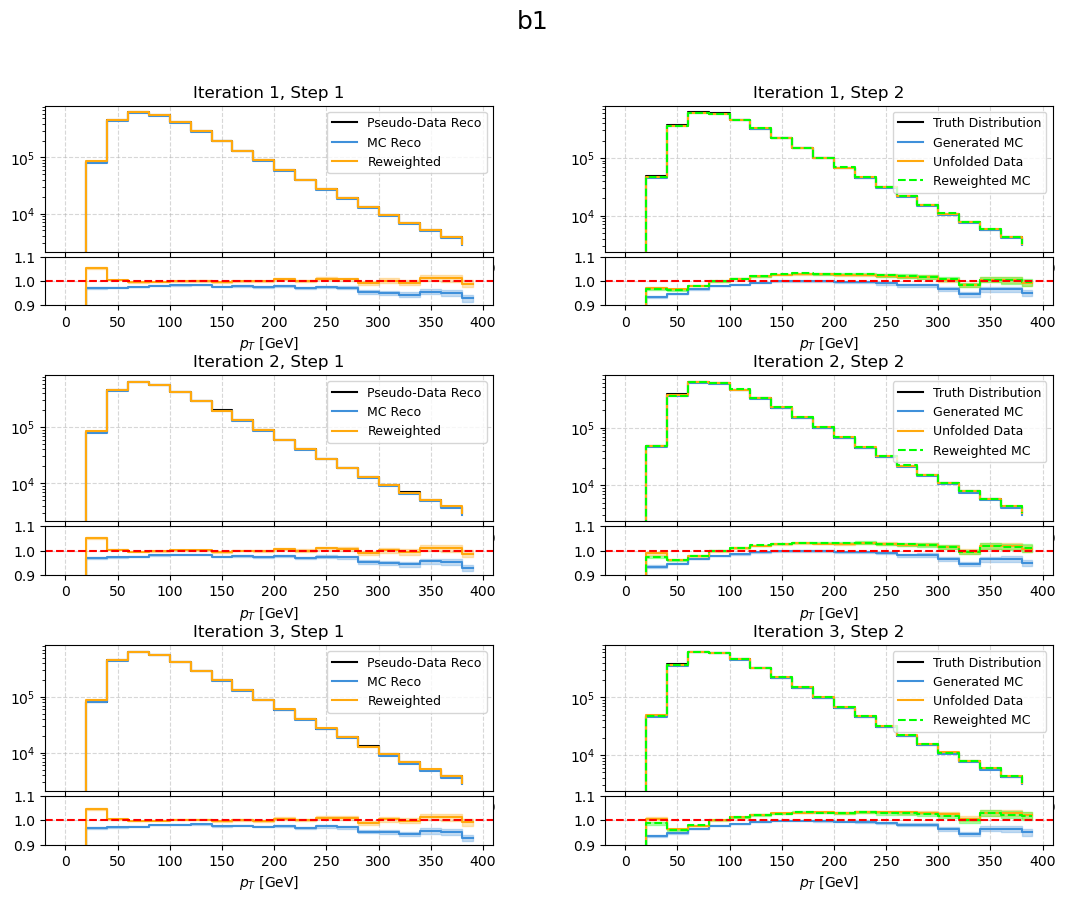

In [19]:
particle_index = 1
fig = plot_all_iterations_updated(
    n_iterations,
    weights_pull_list=weights_pull_list,
    weights_push_list=weights_push_list,
    logx=False
)
plt.show()

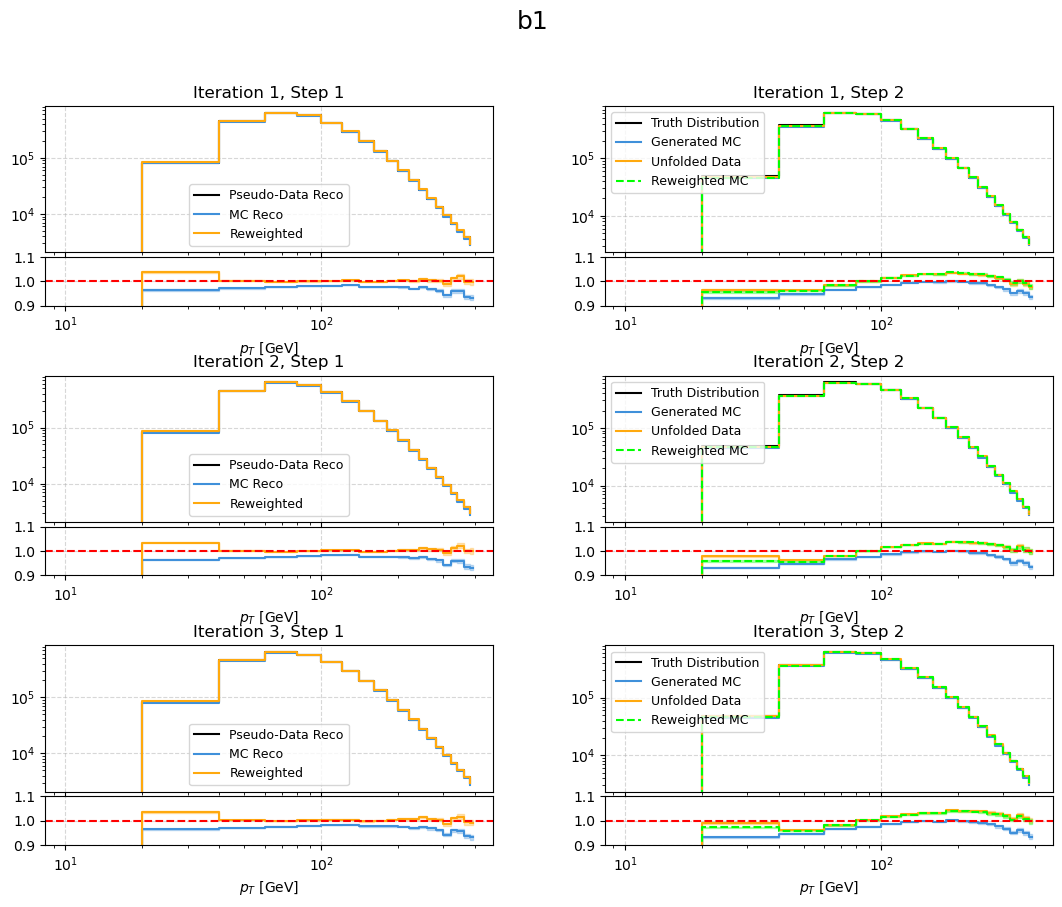

In [14]:
particle_index = 1
fig = plot_all_iterations_updated(
    n_iterations,
    weights_pull_list=weights_pull_list,
    weights_push_list=weights_push_list,
    logx=True
)
plt.show()

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

pdfname = os.path.join(weight_folder, "pc_unfolding_14_ensembling_log.pdf")
with PdfPages(pdfname) as pdf:
    for particle_index in range(len(particles)):      
        fig = plot_all_iterations_updated(n_iterations=3, weights_pull_list=weights_pull_list, weights_push_list=weights_push_list, logx=True)
        pdf.savefig(fig)                             
        plt.close(fig)
        print("Added particle index:", particle_index)

print("PDF written:", pdfname)

Added particle index: 0
Added particle index: 1
Added particle index: 2
Added particle index: 3
Added particle index: 4
Added particle index: 5
Added particle index: 6
Added particle index: 7
Added particle index: 8
Added particle index: 9
Added particle index: 10
Added particle index: 11
Added particle index: 12
Added particle index: 13
PDF written: /scratch/mjosef/Unfolding/omnifold/PET/pc_unfolding_14_ensembling_log.pdf


In [22]:
from matplotlib.backends.backend_pdf import PdfPages

pdfname = os.path.join(weight_folder, "pc_unfolding_14_ensembling.pdf")
with PdfPages(pdfname) as pdf:
    for particle_index in range(len(particles)):      
        fig = plot_all_iterations_updated(n_iterations=3, weights_pull_list=weights_pull_list, weights_push_list=weights_push_list, logx=False)
        pdf.savefig(fig)                             
        plt.close(fig)
        print("Added particle index:", particle_index)

print("PDF written:", pdfname)

Added particle index: 0
Added particle index: 1
Added particle index: 2
Added particle index: 3
Added particle index: 4
Added particle index: 5
Added particle index: 6
Added particle index: 7
Added particle index: 8
Added particle index: 9
Added particle index: 10
Added particle index: 11
Added particle index: 12
Added particle index: 13
PDF written: /scratch/mjosef/Unfolding/omnifold/PET/pc_unfolding_14_ensembling.pdf


In [ ]:
def build_row_matrix(
    truth_values,
    reco_values,
    weights,
    bins,
):
    """
    Build response matrix with:
      rows    = truth bins
      columns = reco bins

    R[j, i] = P(reco=i | truth=j)
    """
    n_truth = len(bins) - 1
    n_reco  = len(bins) - 1

    R = np.zeros((n_truth, n_reco))

    # fill raw counts
    for t, r, w in zip(truth_values, reco_values, weights):
        j = np.digitize(t, bins) - 1
        i = np.digitize(r, bins) - 1
        if 0 <= j < n_truth and 0 <= i < n_reco:
            R[j, i] += w

    # normalize rows (per truth bin)
    row_sums = R.sum(axis=1)
    nonzero = row_sums > 0
    R[nonzero, :] /= row_sums[nonzero, None]

    return R


def build_column_matrix(
    truth_values,
    reco_values,
    weights,
    bins,
):
    """
    Build response matrix with:
      rows    = truth bins
      columns = reco bins

    R[j, i] = P(truth=j | reco=i)

    This is obtained by column-normalizing the same raw matrix.
    """
    n_truth = len(bins) - 1
    n_reco  = len(bins) - 1

    R = np.zeros((n_truth, n_reco))

    # fill raw counts
    for t, r, w in zip(truth_values, reco_values, weights):
        j = np.digitize(t, bins) - 1
        i = np.digitize(r, bins) - 1
        if 0 <= j < n_truth and 0 <= i < n_reco:
            R[j, i] += w

    # normalize columns (per reco bin)
    col_sums = R.sum(axis=0)
    nonzero = col_sums > 0
    R[:, nonzero] /= col_sums[None, nonzero]

    return R


particle_index = 1

In [20]:
R_pre_fine = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 81)
)
R_pre_medium = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 21)
)
R_pre_coarse = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 9)
)
Rinv_pre_fine = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 81)
)
Rinv_pre_medium = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 21)
)
Rinv_pre_coarse = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight,
    bins         = np.linspace(0, 400, 9)
)

R_pre_fine_inv = np.linalg.pinv(R_pre_fine)
R_pre_medium_inv = np.linalg.pinv(R_pre_medium)
R_pre_coarse_inv = np.linalg.pinv(R_pre_coarse)


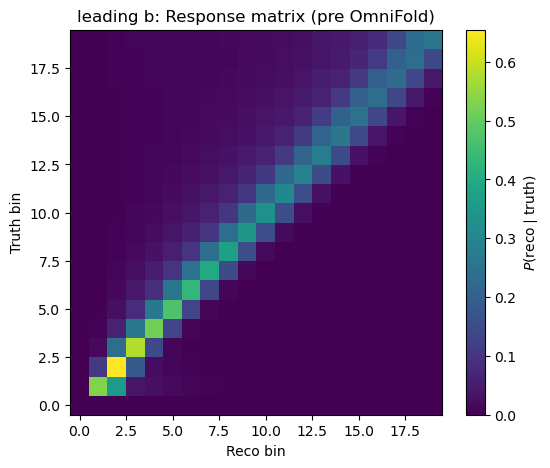

In [26]:
plt.figure(figsize=(6,5))
plt.imshow(
    R_pre,
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.colorbar(label=r"$P(\mathrm{reco} \mid \mathrm{truth})$")
plt.xlabel("Reco bin")
plt.ylabel("Truth bin")
plt.title(f"{'leading b'}: Response matrix (pre OmniFold)")
plt.show()

In [21]:
R_post_fine = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 81)
)

R_post_medium = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 21),
)

R_post_coarse = build_row_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 9),
)
Rinv_post_fine = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 81)
)
Rinv_post_medium = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 21)
)
Rinv_post_coarse = build_column_matrix(
    truth_values = pythia_truth_test[:, particle_index, 0],
    reco_values  = pythia_reco_test[:, particle_index, 0],
    weights      = testset_loader.weight * weights_push_list[-1],
    bins         = np.linspace(0, 400, 9)
)

R_post_fine_inv = np.linalg.pinv(R_post_fine)
R_post_medium_inv = np.linalg.pinv(R_post_medium)
R_post_coarse_inv = np.linalg.pinv(R_post_coarse)

/tmp/ipykernel_1555279/2260372848.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


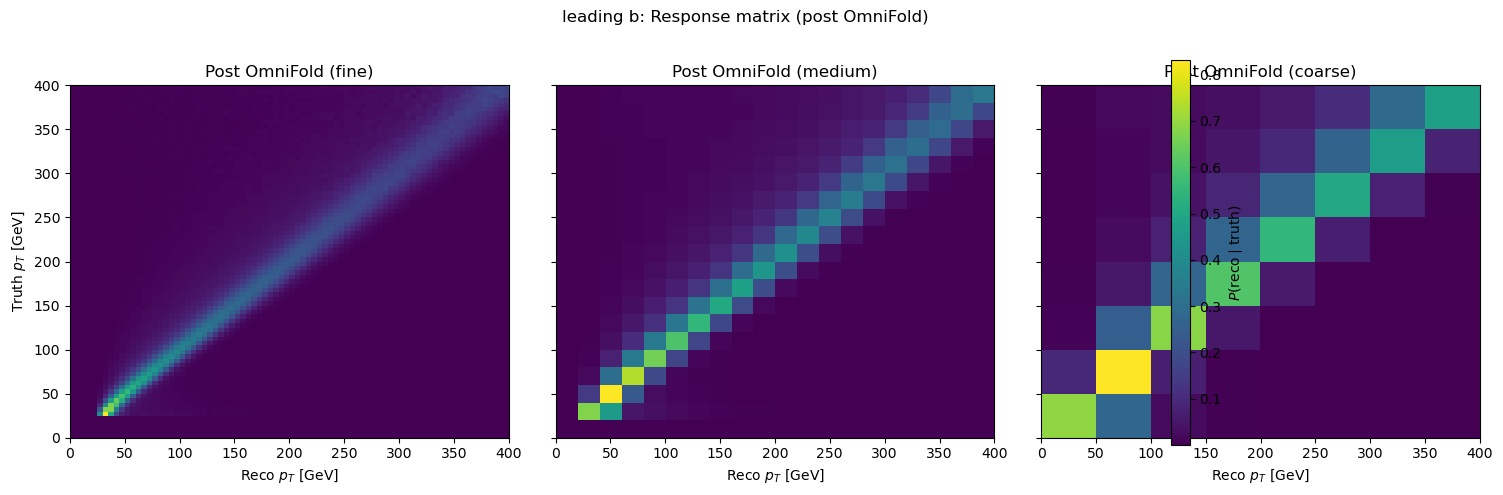

In [12]:
bins_fine   = np.linspace(0, 400, 81)
bins_medium = np.linspace(0, 400, 21)
bins_coarse = np.linspace(0, 400, 9)

bin_sets = [(bins_fine, bins_fine), (bins_medium, bins_medium), (bins_coarse, bins_coarse)]
Rs = [R_post_fine, R_post_medium, R_post_coarse]
labels = ['fine', 'medium', 'coarse']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, R, (truth_bins, reco_bins), label in zip(axes, Rs, bin_sets, labels):
    extent = [reco_bins[0], reco_bins[-1], truth_bins[0], truth_bins[-1]]
    im = ax.imshow(R, origin='lower', aspect='auto', cmap='viridis', extent=extent)
    ax.set_title(f"Post OmniFold ({label})")
    ax.set_xlabel("Reco $p_T$ [GeV]")
    ax.set_xlim(reco_bins[0], reco_bins[-1])

axes[0].set_ylabel("Truth $p_T$ [GeV]")
fig.colorbar(im, ax=axes.ravel(), label=r"$P(\mathrm{reco} \mid \mathrm{truth})$")
fig.suptitle("leading b: Response matrix (post OmniFold)")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [13]:
reco_values  = herwig_reco[:, particle_index, 0]
truth_values = herwig_truth[:, particle_index, 0]
weights      = herwig_loader.weight
def make_hist(values, bins, weights):
    return np.histogram(values, bins=bins, weights=weights)[0]


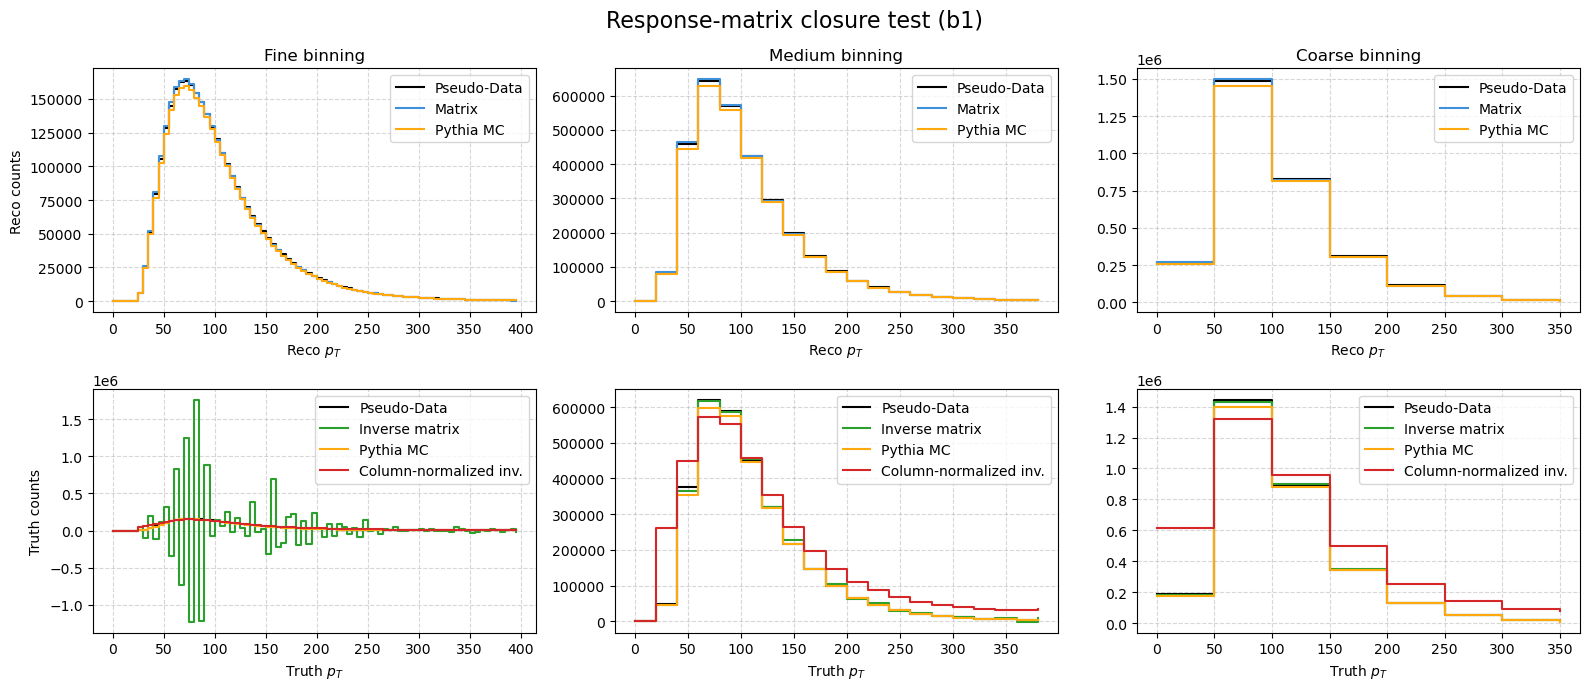

In [30]:
binnings = {
    "Fine":   bins_fine,
    "Medium": bins_medium,
    "Coarse": bins_coarse,
}

R_matrices = {
    "Fine":   R_pre_fine,
    "Medium": R_pre_medium,
    "Coarse": R_pre_coarse,
}

R_matrices_inv = {
    "Fine":   R_pre_fine_inv,
    "Medium": R_pre_medium_inv,
    "Coarse": R_pre_coarse_inv,
}

Rcol_matrices = {
    "Fine":   Rinv_post_fine,
    "Medium": Rinv_post_medium,
    "Coarse": Rinv_post_coarse,
}

fig, axes = plt.subplots(
    2, 3,
    figsize=(16, 7),
    #sharey='row'
)

for col, (label, bins) in enumerate(binnings.items()):

    # --- Histograms ---
    reco_hist = make_hist(reco_values, bins, weights)
    reco_pythia_hist = make_hist(pythia_reco_test[:, particle_index, 0], bins, testset_loader.weight)
    truth_hist = make_hist(truth_values, bins, weights)
    truth_pythia_hist = make_hist(pythia_truth_test[:, particle_index, 0], bins, testset_loader.weight)


    # --- Matrix predictions ---
    R = R_matrices[label]
    Rinv = R_matrices_inv[label]
    Rcol = Rcol_matrices[label]

    reco_pred  = truth_hist @ R
    truth_pred = reco_hist @ Rinv
    truth_pred_col = Rcol.T @ reco_hist.T


    x = bins[:-1]

    # =========================
    # Top row: Reco
    # =========================
    ax = axes[0, col]
    ax.step(x, reco_hist, where="post", label="Pseudo-Data", color="black")
    ax.step(x, reco_pred, where="post", label="Matrix", color="#3f90da")
    ax.step(x, reco_pythia_hist, where="post", label="Pythia MC", color="#ffa90e")

    ax.set_title(f"{label} binning")
    ax.set_xlabel("Reco $p_T$")
    if col == 0:
        ax.set_ylabel("Reco counts")

    ax.grid(True, ls="--", alpha=0.5)
    ax.legend()

    # =========================
    # Bottom row: Truth
    # =========================
    ax = axes[1, col]
    ax.step(x, truth_hist, where="post", label="Pseudo-Data", color="black")
    ax.step(x, truth_pred, where="post", label="Inverse matrix", color="#2ca02c")
    ax.step(x, truth_pythia_hist, where="post", label="Pythia MC", color="#ffa90e")
    ax.step(x, truth_pred_col, where="post", label="Column-normalized inv.", color="#d62728")

    ax.set_xlabel("Truth $p_T$")
    if col == 0:
        ax.set_ylabel("Truth counts")

    ax.grid(True, ls="--", alpha=0.5)
    ax.legend()

fig.suptitle(
    f"Response-matrix closure test ({particles[particle_index]})",
    fontsize=16
)
plt.tight_layout()
plt.show()


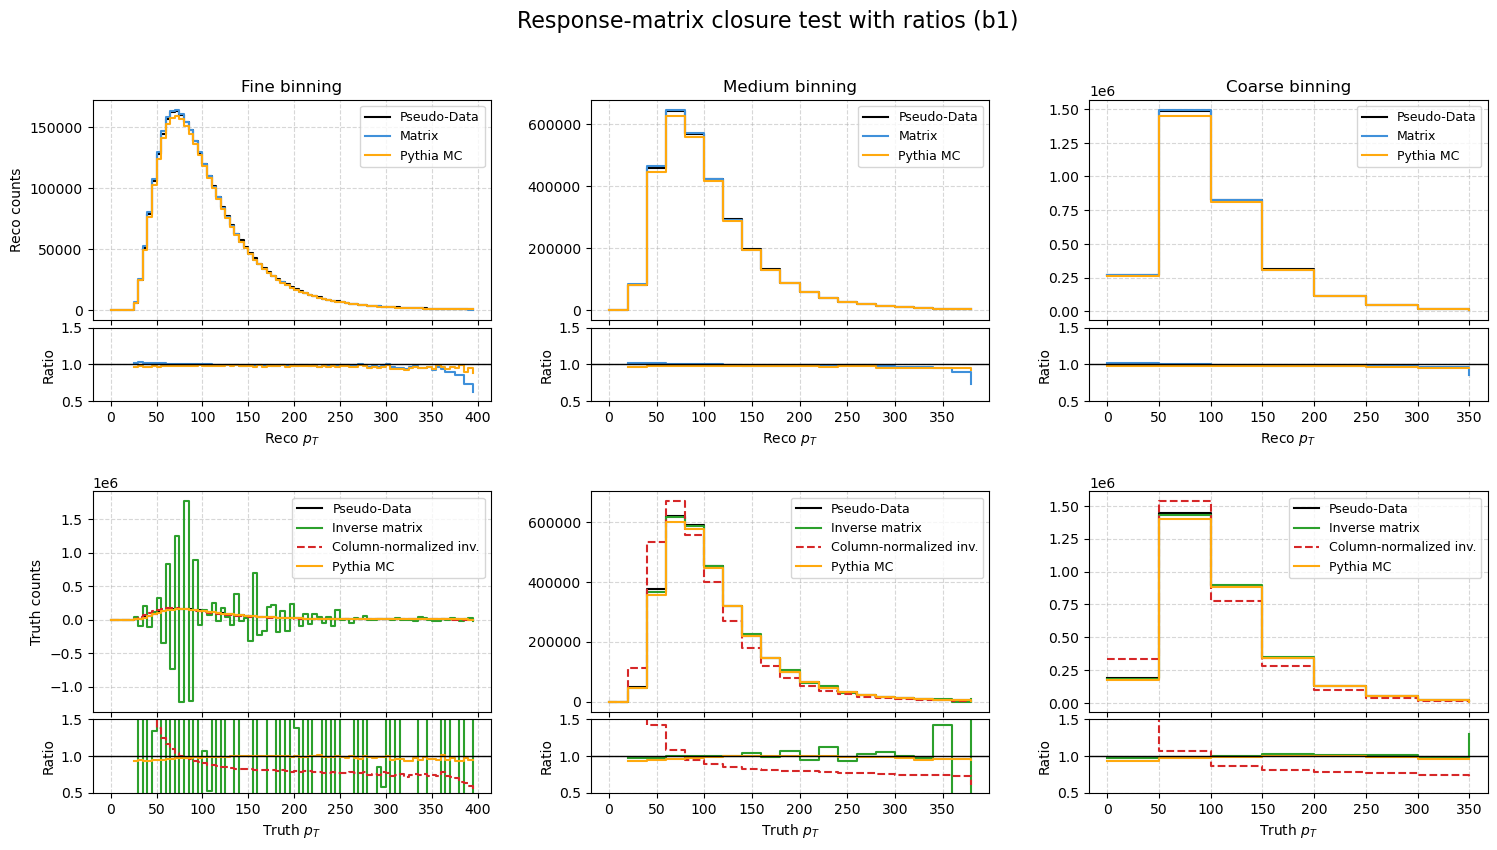

In [27]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def safe_ratio(num, den):
    r = np.ones_like(num, dtype=float)
    mask = den > 0
    r[mask] = num[mask] / den[mask]
    r[~mask] = np.nan
    return r


fig = plt.figure(figsize=(18, 9))
outer = GridSpec(2, 3, figure=fig, wspace=0.25, hspace=0.30)

for col, (label, bins) in enumerate(binnings.items()):

    # --- Histograms ---
    reco_hist = make_hist(reco_values, bins, weights)
    reco_pythia_hist = make_hist(
        pythia_reco_test[:, particle_index, 0],
        bins,
        testset_loader.weight,
    )

    truth_hist = make_hist(truth_values, bins, weights)
    truth_pythia_hist = make_hist(
        pythia_truth_test[:, particle_index, 0],
        bins,
        testset_loader.weight,
    )

    # --- Matrix predictions ---
    R    = R_matrices[label]
    Rinv = R_matrices_inv[label]
    Rcol = Rcol_matrices[label]

    reco_pred        = truth_hist @ R
    truth_pred       = reco_hist @ Rinv
    truth_pred_col   = reco_hist @ Rcol.T

    x = bins[:-1]

    # =========================
    # RECO (top row)
    # =========================
    sub = GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer[0, col],
        height_ratios=[3, 1], hspace=0.05
    )

    ax = fig.add_subplot(sub[0])
    rax = fig.add_subplot(sub[1], sharex=ax)

    ax.step(x, reco_hist, where="post", color="black", label="Pseudo-Data")
    ax.step(x, reco_pred, where="post", color="#3f90da", label="Matrix")
    ax.step(x, reco_pythia_hist, where="post", color="#ffa90e", label="Pythia MC")

    ax.set_title(f"{label} binning")
    if col == 0:
        ax.set_ylabel("Reco counts")
    ax.grid(True, ls="--", alpha=0.5)
    ax.legend(fontsize=9)

    rax.step(x, safe_ratio(reco_pred, reco_hist),
             where="post", color="#3f90da")
    rax.step(x, safe_ratio(reco_pythia_hist, reco_hist),
             where="post", color="#ffa90e")

    rax.axhline(1.0, color="black", lw=1)
    rax.set_ylim(0.5, 1.5)
    rax.set_ylabel("Ratio")
    rax.set_xlabel("Reco $p_T$")
    rax.grid(True, ls="--", alpha=0.5)

    plt.setp(ax.get_xticklabels(), visible=False)

    # =========================
    # TRUTH (bottom row)
    # =========================
    sub = GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer[1, col],
        height_ratios=[3, 1], hspace=0.05
    )

    ax = fig.add_subplot(sub[0])
    rax = fig.add_subplot(sub[1], sharex=ax)

    ax.step(x, truth_hist, where="post", color="black", label="Pseudo-Data")
    ax.step(x, truth_pred, where="post", color="#2ca02c", label="Inverse matrix")
    ax.step(x, truth_pred_col, where="post", color="#d62728",
            linestyle="--", label="Column-normalized inv.")
    ax.step(x, truth_pythia_hist, where="post", color="#ffa90e", label="Pythia MC")

    if col == 0:
        ax.set_ylabel("Truth counts")
    ax.grid(True, ls="--", alpha=0.5)
    ax.legend(fontsize=9)

    rax.step(x, safe_ratio(truth_pred, truth_hist),
             where="post", color="#2ca02c")
    rax.step(x, safe_ratio(truth_pred_col, truth_hist),
             where="post", color="#d62728", linestyle="--")
    rax.step(x, safe_ratio(truth_pythia_hist, truth_hist),
             where="post", color="#ffa90e")

    rax.axhline(1.0, color="black", lw=1)
    rax.set_ylim(0.5, 1.5)
    rax.set_ylabel("Ratio")
    rax.set_xlabel("Truth $p_T$")
    rax.grid(True, ls="--", alpha=0.5)

    plt.setp(ax.get_xticklabels(), visible=False)


fig.suptitle(
    f"Response-matrix closure test with ratios ({particles[particle_index]})",
    fontsize=16
)
plt.show()


In [37]:
truth_hist = np.histogram(
    herwig_truth[:, particle_index, 0],
    bins=pt_binning['b1'],
    weights=herwig_loader.weight
)[0]

reco_pred = truth_hist @ R_pre

In [35]:
reco_hist = np.histogram(
    herwig_reco[:, particle_index, 0],
    bins=pt_binning['b1'],
    weights=herwig_loader.weight
)[0]

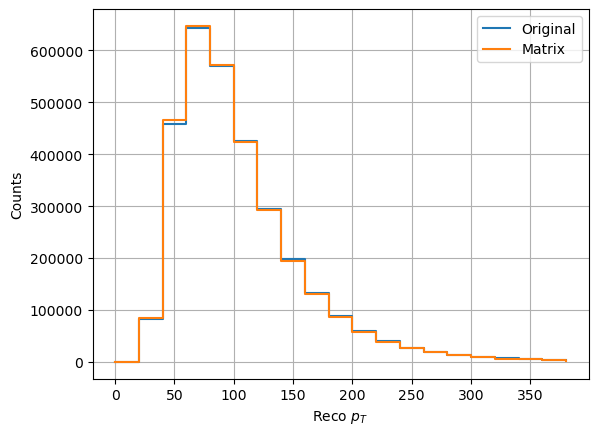

In [38]:
plt.step(pt_binning['b1'][:-1], reco_hist,  where='post', label="Original")
plt.step(pt_binning['b1'][:-1], reco_pred,  where='post', label="Matrix")
plt.xlabel("Reco $p_T$")
plt.ylabel("Counts")
plt.legend()
plt.grid()
plt.show()

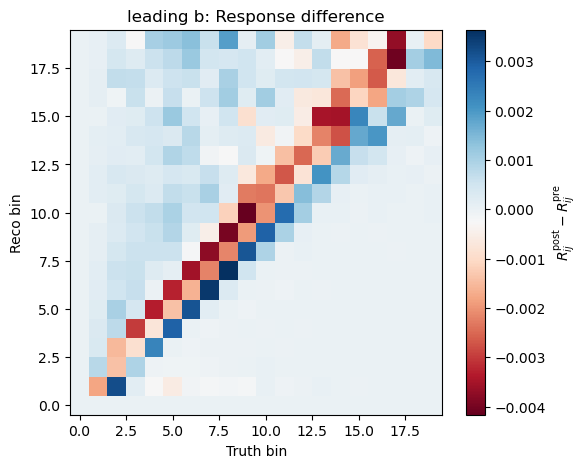

In [31]:
plt.figure(figsize=(6,5))
plt.imshow(R_post - R_pre, origin='lower', aspect='auto', cmap='RdBu')
plt.colorbar(label=r"$R_{ij}^{\rm post} - R_{ij}^{\rm pre}$")
plt.xlabel("Truth bin")
plt.ylabel("Reco bin")
plt.title(f"{"leading b"}: Response difference")
plt.show()

In [32]:
eff = R_post.sum(axis=1)

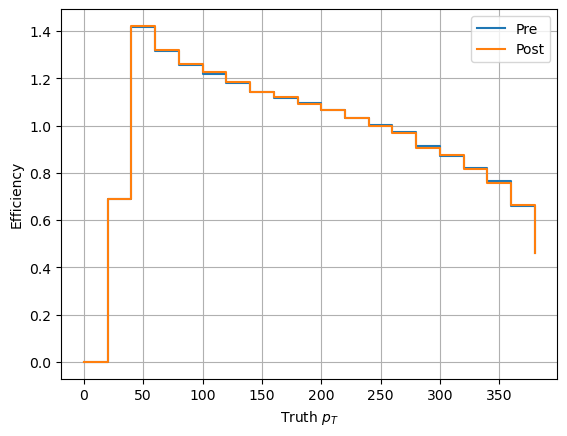

In [33]:
eff_pre  = R_pre.sum(axis=0)
eff_post = R_post.sum(axis=0)

plt.step(pt_binning['b1'][:-1], eff_pre,  where='post', label="Pre")
plt.step(pt_binning['b1'][:-1], eff_post, where='post', label="Post")
plt.xlabel("Truth $p_T$")
plt.ylabel("Efficiency")
plt.legend()
plt.grid()
plt.show()

### Sanity Check

In [39]:
R_test = build_response_matrix(
    truth_values = herwig_truth[:, particle_index, 0],
    reco_values  = herwig_reco[:, particle_index, 0],
    weights      = herwig_loader.weight,
    bins         = pt_binning['b1']
)

In [42]:
truth_hist = np.histogram(
    herwig_truth[:, particle_index, 0],
    bins=pt_binning['b1'],
    weights=herwig_loader.weight
)[0]

reco_pred = truth_hist @ R_test

reco_hist = np.histogram(
    herwig_reco[:, particle_index, 0],
    bins=pt_binning['b1'],
    weights=herwig_loader.weight
)[0]

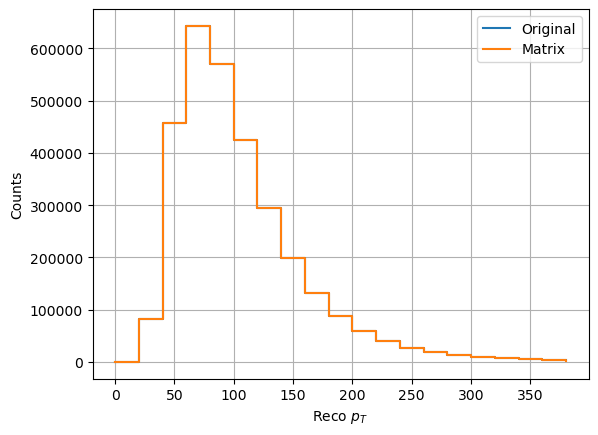

In [43]:
plt.step(pt_binning['b1'][:-1], reco_hist,  where='post', label="Original")
plt.step(pt_binning['b1'][:-1], reco_pred,  where='post', label="Matrix")
plt.xlabel("Reco $p_T$")
plt.ylabel("Counts")
plt.legend()
plt.grid()
plt.show()

In [44]:
R_test_inv = np.linalg.pinv(R_test)

In [46]:
I_truth = R_test @ R_test_inv       # should be ~ identity in truth space
I_reco  = R_test_inv @ R_test        # should be ~ identity in reco space

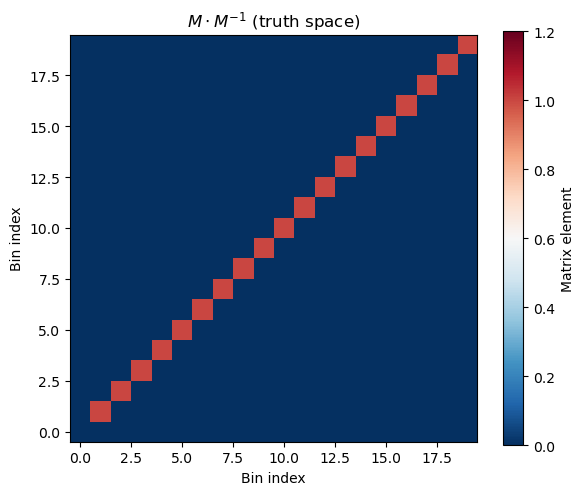

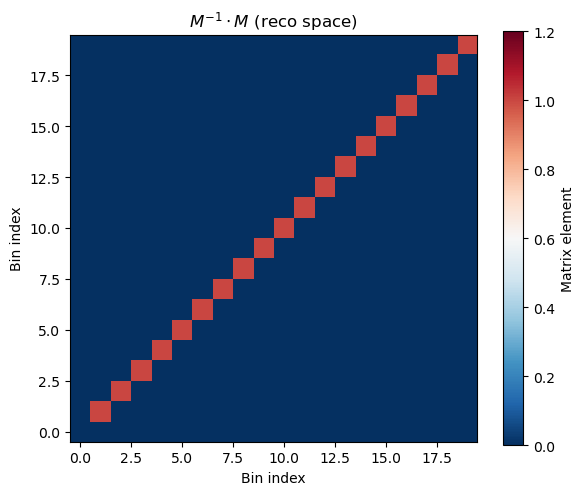

In [47]:
def plot_identity_check(I, title, vmin=0.0, vmax=1.2):
    plt.figure(figsize=(6,5))
    im = plt.imshow(I, origin="lower", cmap="RdBu_r",
                    vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Matrix element")
    plt.xlabel("Bin index")
    plt.ylabel("Bin index")
    plt.title(title)
    plt.tight_layout()
    plt.show()
plot_identity_check(I_truth, r"$M \cdot M^{-1}$ (truth space)")
plot_identity_check(I_reco,  r"$M^{-1} \cdot M$ (reco space)")
